# ⚙️ SmartBin — Versió 2.0  
### Traducció del notebook de [Recyclable and Household Waste Classification](https://www.kaggle.com/code/alistairking/recyclable-and-household-waste-classification-code)

> **Aquest notebook ha estat generat amb assistència d’intel·ligència artificial, però totes les decisions sobre les tècniques i metodologies utilitzades han estat preses per una persona humana.**

---

## 🧩 Descripció general

Aquest notebook és la **traducció i adaptació** al català del projecte original publicat a Kaggle per a la classificació d’imatges de residus mitjançant intel·ligència artificial.  
Forma part del procés d’aprenentatge i desenvolupament del projecte **SmartBin**, una paperera intel·ligent capaç de reconèixer diferents tipus de residus a partir d’imatges capturades per càmera.  

L’objectiu principal d’aquesta versió és oferir una base sòlida per entendre el funcionament d’un model de **classificació d’imatges amb xarxes neuronals convolucionals (CNN)**, seguint el mateix flux de treball que el notebook original anglès.  
Aquest procés inclou la càrrega del conjunt de dades, el preprocessament d’imatges, la definició del model, el seu entrenament i l’avaluació final de resultats.

> **Dataset utilitzat:** [Recyclable and Household Waste Classification (Kaggle)](https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification)


Aquesta versió 2.0 serveix com a **punt de partida essencial** per aprendre a utilitzar la intel·ligència artificial aplicada a la classificació d’imatges, sent una **base pràctica i formativa** sobre la qual s’han desenvolupat les versions posteriors (2.1, 2.2 i 2.3) del projecte SmartBin.

---
## Funcionament del codi
### Importació de Llibreries

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

Primer es comença important les seguents llibreries per a poder iniciar
- os for file and directory operations
- torch and torch.nn for building and training the neural network
- torch.optim for optimization algorithms
- torch.utils.data for creating data loaders and custom datasets
- torchvision.transforms for image transformations
- PIL for image loading and manipulation
- matplotlib.pyplot for visualizing images and plots
- random for random number generation

### Importació de Dades i creació de Classes

# Classe personalitzada de Dataset

Definim una classe anomenada `WasteDataset` que hereta de la classe `Dataset` de PyTorch. Aquesta classe s'encarrega de **carregar i preprocesar les imatges del conjunt de dades**.

---

## Inicialització (`__init__`)

El mètode `__init__` rep els següents paràmetres:

- `root_dir`: la carpeta arrel que conté les imatges del dataset.
- `split`: la divisió del conjunt de dades (`train`, `val`, o `test`).
- `transform`: transformacions opcionals a aplicar a les imatges.

A dins del mètode `__init__` es fan les següents accions:

- Es guarden els valors de `root_dir`, `transform` i `split`.
- Es llisten les carpetes dins de `root_dir` per obtenir les classes.
- S'inicialitzen dues llistes buides: `image_paths` i `labels`.
- Es recorre cada carpeta de classe i les seves subcarpetes (`default` i `real_world`).
- Es barregen aleatòriament els noms de les imatges dins de cada subcarpeta.
- Segons el valor de `split`, es selecciona una porció de les imatges:
  - 60% per entrenament
  - 20% per validació
  - 20% per test
- S’afegeixen els camins de les imatges i les etiquetes corresponents a les llistes.

---

## Longitud i accés a les imatges

### `__len__`
Retorna el nombre total d’imatges del dataset.

### `__getitem__`
Rep un índex i retorna la imatge i l’etiqueta corresponent. Fa:

- Recupera el camí i l’etiqueta segons l’índex.
- Obre la imatge amb `Image.open()` i la converteix a format RGB.
- Aplica les transformacions, si n’hi ha.
- Retorna la imatge transformada i la seva etiqueta.

---

Aquesta classe personalitzada de dataset ens permet **carregar i preparar fàcilment les imatges de residus** per a entrenament, validació i test.


In [4]:
# Define the dataset class (modified to include a split parameter)
class WasteDataset(Dataset): #Creem una classe a partir de la plantilla Dataset
    def __init__(self, root_dir, split, transform=None): #Especifiquem cadascun dels paràmetres
        self.root_dir = root_dir
        self.transform = transform 
        self.classes = sorted(os.listdir(root_dir)) 
        self.image_paths = [] 
        self.labels = [] 
        
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.shuffle(image_names)
                
                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]
                
                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Arquitectura del Model CNN

Definim una xarxa neuronal convolucional (CNN) anomenada `CNN` que hereta de la classe `nn.Module` de PyTorch.  
Aquesta arquitectura està formada per capes convolucionals, capes de pooling i capes completament connectades (fully connected).

---

## Inicialització

El mètode `__init__` rep un únic paràmetre:

- `num_classes`: el nombre de classes de sortida per a la tasca de classificació.

Dins de `__init__` definim les següents capes:

- `conv1`: capa convolucional 2D amb:
  - 3 canals d’entrada
  - 32 canals de sortida
  - mida de filtre (kernel) 3
  - pas (stride) de 1
  - padding de 1

- `relu`: funció d’activació ReLU

- `maxpool`: capa de max pooling 2D amb:
  - kernel de mida 2
  - stride de 2

- `conv2`: una altra capa convolucional 2D amb:
  - 32 canals d’entrada
  - 64 canals de sortida
  - kernel de 3, stride 1, padding 1

- `fc1`: capa completament connectada (fully connected) que transforma la sortida de `conv2` en 512 neurones

- `fc2`: última capa que transforma les 512 neurones en el nombre de classes de sortida

---

## Forward Pass (propagació endavant)

El mètode `forward` defineix com flueix la informació pel model.

Pren una entrada `x` i fa:

1. Passar `x` per `conv1`, aplicar `relu` i després `maxpool`
2. Passar la sortida per `conv2`, aplicar `relu` i `maxpool`
3. Aplanar la sortida amb `x.view(x.size(0), -1)`
4. Passar el tensor aplanat per `fc1`, aplicar `relu`
5. Passar la sortida per `fc2` per obtenir la sortida final

---

## Què fa aquest model?

Aquest model CNN està dissenyat per **aprendre característiques jeràrquiques** de les imatges d’entrada i fer prediccions basades en aquestes característiques.

- Les **capes convolucionals** capturen patrons locals
- Les **capes de pooling** redueixen la mida espacial
- Les **fully connected** fan la classificació final


In [6]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Ruta del Dataset i Hiperparàmetres

Definim la ruta del conjunt de dades i alguns dels principals hiperparàmetres:

- `dataset_path`: ruta cap a la carpeta que conté les imatges del dataset.
- `batch_size`: nombre de mostres que s’utilitzen en cada lot (batch) durant l’entrenament i la validació.
- `num_epochs`: nombre total de vegades que el model veurà tot el conjunt de dades durant l’entrenament.
- `learning_rate`: la taxa d’aprenentatge utilitzada per l’optimitzador, que controla la velocitat amb què el model actualitza els seus pesos.

---

Aquests hiperparàmetres es poden **ajustar segons les necessitats específiques** del projecte i els **recursos computacionals disponibles** (GPU, memòria, temps, etc.).


In [8]:
# Set the dataset path and hyperparameters
dataset_path = 'images'
batch_size = 16
num_epochs = 5
learning_rate = 0.001

# Preprocessament de Dades i Carregadors (Data Loaders)

Definim una composició de transformacions per a les imatges utilitzant `transforms.Compose`:

- `transforms.Resize((224, 224))`: redimensiona totes les imatges a una mida fixa de 224x224 píxels.
- `transforms.ToTensor()`: converteix les imatges a tensors de PyTorch.
- `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: normalitza els valors dels píxels segons mitjanes i desviacions típiques estàndard (com ImageNet).

Aquestes transformacions asseguren que totes les imatges es preprocessin de forma coherent abans d’entrar al model.

---

## Creació dels datasets

Creem instàncies de la classe `WasteDataset` per als tres conjunts de dades:

- Entrenament (`train`)
- Validació (`val`)
- Test (`test`)

Passant-li els paràmetres `dataset_path`, `split` i `transform`, les imatges de cada conjunt es carregaran ja transformades.

---

## Creació dels `DataLoader`

Finalment, creem els carregadors de dades (`DataLoader`) per a cada conjunt:

- `train_dataloader`: carrega les dades d’entrenament en lots de mida `batch_size` i les barreja (`shuffle=True`).
- `val_dataloader`: carrega les dades de validació sense barrejar.
- `test_dataloader`: carrega les dades de test sense barrejar.

Els `DataLoader` són útils perquè permeten **iterar pel dataset de forma eficient**, gestionant el **batching i el shuffling automàticament** durant l’entrenament i l’avaluació.


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = WasteDataset(dataset_path, split='train', transform=transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Inicialització del Model

Creem una instància del model CNN, passant-li el paràmetre `num_classes`.  
Aquest valor es determina amb `len(dataset.classes)`, que ens dona el **nombre total de classes diferents** al dataset.  
Això assegura que **la capa de sortida del model tingui tantes neurones com classes**.

Un cop creat, movem el model a la **GPU** amb `.to('cuda')` per aprofitar la potència de càlcul de la targeta gràfica i fer l’entrenament i inferència molt més ràpids.

---

# Funció de Pèrdua

Definim la funció de pèrdua amb:

```python
loss_function = nn.CrossEntropyLoss()


In [10]:
num_classes = len(train_dataset.classes)
model = CNN(num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Bucle d'Entrenament

Definim dues llistes: `train_losses` i `val_losses` per **guardar la pèrdua (loss)** d'entrenament i de validació de cada època.  
Aquestes llistes ens ajudaran a **fer un seguiment del rendiment del model** durant l'entrenament.

---

## Funcionament del bucle d'entrenament

El bucle recorre el nombre d’èpoques especificat (`num_epochs`). A cada època es fan dues fases:

---

### 🟢 Fase d'Entrenament

1. Posem el model en **mode entrenament** amb `model.train()`.  
   Això activa capes com *dropout* i *batch normalization* per actualitzar-se.

2. Inicialitzem `train_loss` per acumular la pèrdua d’entrenament d’aquesta època.

3. Recorrem les dades d’entrenament (`train_dataloader`):

   - Passem les imatges i etiquetes a la GPU amb `.to('cuda')`
   - **Forward pass**: passem les imatges pel model → sortides
   - Calculem la **pèrdua** amb `criterion(outputs, labels)`
   - **Backward pass**:
     - Esborrem els gradients anteriors amb `optimizer.zero_grad()`
     - Calculem els nous gradients amb `loss.backward()`
     - Actualitzem els pesos amb `optimizer.step()`
   - Afegim la pèrdua del lot al `train_loss`

4. Dividim el `train_loss` total pel nombre de mostres per obtenir la **pèrdua mitjana** de l’època.

5. Afegim aquest valor a `train_losses`.

---

### 🔵 Fase de Validació

1. Posem el model en **mode avaluació** amb `model.eval()`.  
   Això desactiva *dropout* i *batch norm*.

2. Inicialitzem `val_loss` per acumular la pèrdua de validació.

3. Amb `torch.no_grad()` (per no calcular gradients i anar més ràpid), recorrem les dades de validació (`val_dataloader`):

   - Imatges i etiquetes a la GPU
   - Forward pass per obtenir sortides
   - Calculem la pèrdua
   - Afegim la pèrdua del lot a `val_loss`

4. Dividim pel nombre de mostres i afegim el resultat a `val_losses`.

---

### ℹ️ Al final de cada època:

- Imprimim el número d’època, la pèrdua d'entrenament i la de validació.

Quan acaben totes les èpoques, es mostra un missatge que indica que l’entrenament ha finalitzat.

---

Aquest procés permet al model **aprendre progressivament** i controlar **si millora o es sobreentrena** gràcies a la comparació entre entrenament i validació.


In [11]:
# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

Epoch [1/5], Train Loss: 3.4887, Val Loss: 2.8848
Epoch [2/5], Train Loss: 2.3012, Val Loss: 1.5719
Epoch [3/5], Train Loss: 0.8707, Val Loss: 1.2400
Epoch [4/5], Train Loss: 0.3434, Val Loss: 1.2691
Epoch [5/5], Train Loss: 0.2299, Val Loss: 1.2601
Training completed!


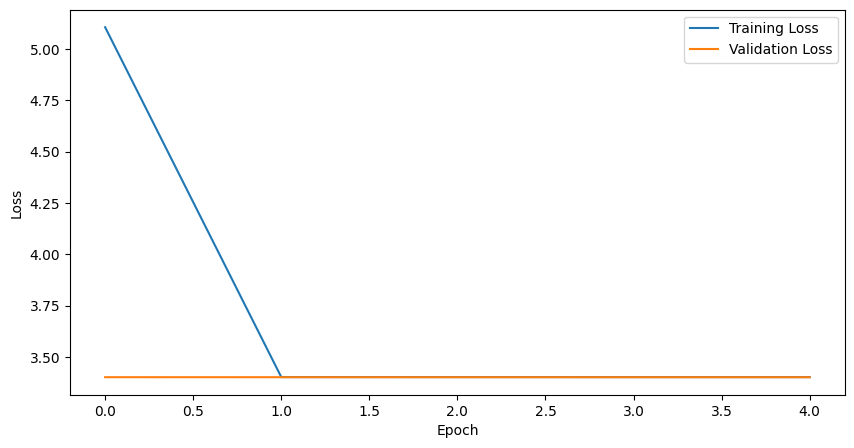

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("grafica_perdues.png")  # pots canviar el nom o el format
plt.show()

In [27]:
import matplotlib.pyplot as plt
import random
import torch
import IPython.display as display

model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    
    selected_images = []
    selected_labels = []
    selected_predicted = []
    
    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')
        
        output = model(image)
        _, predicted = torch.max(output, 1)
        
        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())
        
        if len(selected_labels) == 9:
            break
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        axes[i].set_title(f"True: {train_dataset.classes[selected_labels[i]]}\nPredicted: {train_dataset.classes[selected_predicted[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig("visualitzacio_prediccions.png")
    plt.show()

# Enllaç per descarregar la imatge
display.display(display.FileLink("visualitzacio_prediccions.png"))

NameError: name 'model' is not defined


🎯 Accuracy global: 0.0333

📋 Informe per classe:
                            precision    recall  f1-score   support

              aerosol_cans       0.00      0.00      0.00       100
        aluminum_food_cans       0.00      0.00      0.00       100
        aluminum_soda_cans       0.00      0.00      0.00       100
           cardboard_boxes       0.00      0.00      0.00       100
       cardboard_packaging       0.00      0.00      0.00       100
                  clothing       0.00      0.00      0.00       100
            coffee_grounds       0.00      0.00      0.00       100
disposable_plastic_cutlery       0.00      0.00      0.00       100
                 eggshells       0.00      0.00      0.00       100
                food_waste       0.00      0.00      0.00       100
    glass_beverage_bottles       0.00      0.00      0.00       100
 glass_cosmetic_containers       0.00      0.00      0.00       100
           glass_food_jars       0.03      1.00      0.06       1

C:\Users\Usuario\anaconda3\envs\smartbin\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Usuario\anaconda3\envs\smartbin\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Usuario\anaconda3\envs\smartbin\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

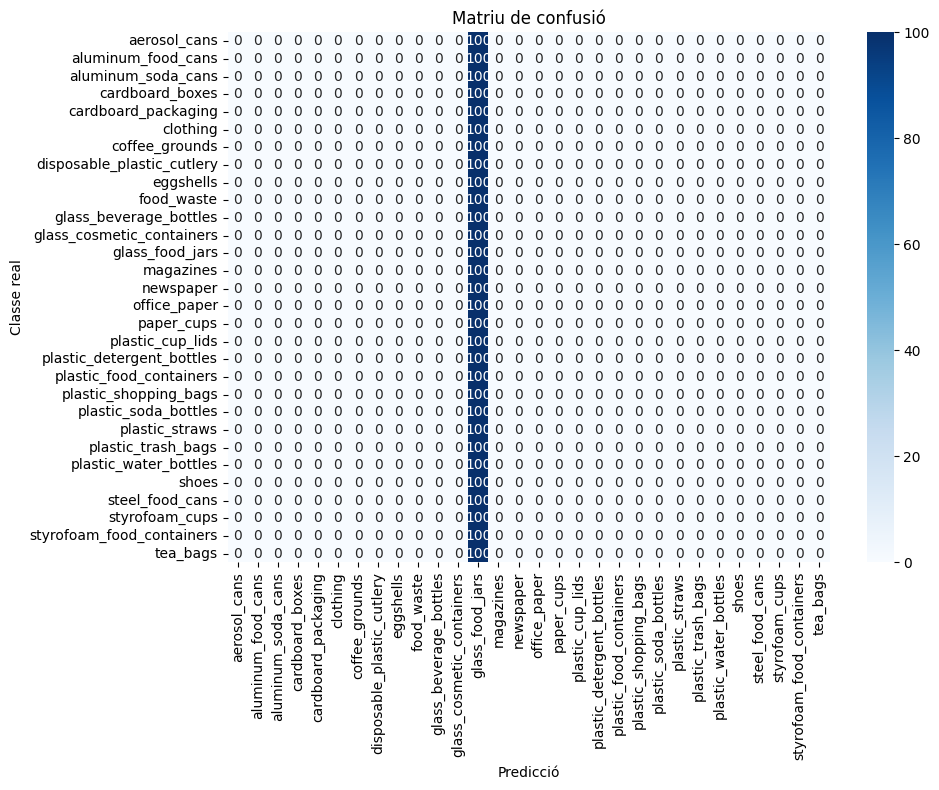

✅ Resultats exportats com a fitxers: informe_metrics.csv i matriu_confusio.csv


In [24]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

# 🧠 Mode avaluació
model.eval()

# 🔄 Recollim les prediccions i etiquetes reals
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 🎯 Accuracy global
acc = accuracy_score(true_labels, predicted_labels)
print(f"\n🎯 Accuracy global: {acc:.4f}\n")

# 📊 Classification report
report = classification_report(true_labels, predicted_labels, target_names=test_dataset.classes, output_dict=True)
print("📋 Informe per classe:")
print(classification_report(true_labels, predicted_labels, target_names=test_dataset.classes))

# 🧩 Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes, cmap="Blues")
plt.xlabel("Predicció")
plt.ylabel("Classe real")
plt.title("Matriu de confusió")
plt.tight_layout()
plt.savefig("matriu_confusio.png")  # Desa la imatge
plt.show()

# 💾 Exportació opcional
# Report com CSV
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("informe_metrics.csv", index=True)

# Matriu de confusió com CSV
df_cm = pd.DataFrame(cm, index=test_dataset.classes, columns=test_dataset.classes)
df_cm.to_csv("matriu_confusio.csv")

print("✅ Resultats exportats com a fitxers: informe_metrics.csv i matriu_confusio.csv")

In [25]:
# Guardar només els pesos del model
torch.save(model.state_dict(), "model_smartbin.pth")

print("✅ Model exportat com a 'model_smartbin.pth'")

✅ Model exportat com a 'model_smartbin.pth'
